# Coursework 2 - Part 1

**Replace CID in the file name with your CID**

# Outline


- [Task 1](#task-1): Classification with a Convolutional Neural Network <a name="index-task-1"></a>
  - [(1.1)](#task-11) <a name="index-task-11"></a>
  - [(1.2)](#task-12) <a name="index-task-12"></a>
  - [(1.3)](#task-13) <a name="index-task-13"></a>
- [Task 2](#task-2): Dimensionality Reduction: PCA vs ISOMAP <a name="index-task-2"></a>
  - [(2.1)](#task-21)
  - [(2.2)](#task-22)
  - [(2.3)](#task-23)  



---



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy
import matplotlib

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Torch imports
import torch
from torch.nn import Sequential, CrossEntropyLoss, Conv2d, MaxPool2d, Flatten, Linear, ReLU, Softmax, Parameter
from torch.utils.data import TensorDataset, DataLoader

In [2]:
star_images_train = np.load('star_images_train.npy')
star_classes_train = np.load('star_classes_train.npy')
star_embeddings_train = np.load('star_embeddings_train.npy')

star_images_test = np.load('star_images_test.npy')
star_classes_test = np.load('star_classes_test.npy')

classes = np.arange(4)

In [3]:
print(star_images_train.shape)
print(star_classes_train.shape)
print(star_embeddings_train.shape)
print(star_images_test.shape)
print(star_classes_test.shape)

(648, 32, 32)
(648,)
(648, 180)
(32, 32, 32)
(32,)


<a name="task-1"></a>

# (1) Task 1: Classification with a Convolutional Neural Network [(index)](#index-task-1)

<a name="task-11"></a>

## (1.1) [(index)](#index-task-11)

*First, split the training dataset in two parts: 75% for the actual training and 25% for the validation set.*

In [4]:
# Split data into training and validation
n = star_images_train.shape[0]
np.random.seed(0)
val_ind = np.random.choice(n, int(0.25*n), replace=False)
train_ind = list(set(range(n)) - set(val_ind))
# Training set
X1_train = star_images_train[train_ind]
X1_val = star_images_train[val_ind]
# Validation set
y1_train = star_classes_train[train_ind]
y1_val = star_classes_train[val_ind]

*Implement a CNN architecture as stated. Use ```Adam``` as the optimisation algorithm and define the loss function as categorical cross-entropy.*

We now build the CNN model in PyTorch to train on the dataset, consisting of:

* A `Conv2d` layer with 4 filters, kernel shape of (5,5) and a `ReLU` activation function
* A `MaxPool2d` layer with a pooling window shape of (2,2) and a stride of 2
* Another `Conv2d` layer with 8 filters, kernel shape of (5,5) and a `ReLU` activation function
* A `Flatten` layer
* A `Linear` layer and a `Softmax` activation

We adjust the function given in the coding task to our requirements. The function below should build and compile this model, using an `Adam` optimiser and a `CrossEntropyLoss` criterion.

In [5]:
def get_model(x_train, n_filters1, k1, pool_size, stride_pool, n_filters2, k2, classes, loss_weight=None):
    """
    CNN model in PyTorch:
    - Layers are Conv2d(+ReLU), MaxPool1d, Conv2d(+ReLU), Flatten and Linear(+Softmax).
    - It features an Adam optimiser and CrossEntropyLoss criterion.
    - Conv1d and Linear layers have regularised weights according to l2_reg.

    Parameters:
    x_train: Training data
    n_filters1: Number of filters to be used in the first convolutional layer
    k1: Kernel size in the first convolutional layer
    pool_size: MaxPool1d window size
    stride_pool: Stride of the MaxPool1d sliding window
    n_filters2: Number of filters to be used in the second convolutional layer
    k2: Kernel size in the second convolutional layer
    classes: List containing the output classes
    l2_reg: Positive float corresponding to the regularisation coefficient of Conv1d (for Task 1.2)
    loss_weight: Weights for our loss function (for Task 1.3)

    Returns:
    Model, criterion and optimiser.

    """

    l_out_conv1 = x_train.shape[1] - k1 + 1 
    l_out_pool = (l_out_conv1 - pool_size) // stride_pool + 1 
    l_out_conv2 = l_out_pool - k2 + 1
    l_in_linear = n_filters2 * l_out_conv2**2

    model = Sequential(
        Conv2d(1, n_filters1, kernel_size=k1),
        ReLU(), 
        MaxPool2d(kernel_size=pool_size, stride=stride_pool),
        Conv2d(n_filters1, n_filters2, kernel_size=k2),
        ReLU(), 
        Flatten(),
        Linear(l_in_linear, len(classes)),
        Softmax(dim=1),
    )
        
    optimiser = torch.optim.Adam(model.parameters())
    criterion = CrossEntropyLoss(weight=loss_weight) # Loss function (with weight for Task 1.3)
    
    return model, criterion, optimiser

In [6]:
# View our CNN architecture
n_filters1 = 4
k1 = 5
pool_size = 2
stride_pool = 2
n_filters2 = 8
k2 = 5

model11, criterion11, optimiser11 = get_model(X1_train, n_filters1, k1, pool_size, stride_pool, n_filters2, k2, classes)

*Run the training for a maximum of 2000 epochs, with batches of size 128. Include early stopping during the training, monitoring the loss as your metric of performance and setting the ```max_patience parameter``` to 150 epochs. During training, also monitor the performance by computing the classification accuracy.*

We implement the ```EarlyStopping``` and ```training_loop``` functions as seen in coding tasks, with adaptations for display and regularisation (for Task **1.2**).

In [7]:
class EarlyStopping:
    """
    EarlyStopping class.

    Attributes:
    max_patience: Amount of epochs with no improvement after which training is stopped.
    patience: Stores the number of epochs with no improvement.
    best_valid_loss: Stores the current value of the best (minimum) validation loss.
    early_stop: True if training needs to be stopped due to the early stopping condition being met.

    Methods:
    step(val_loss):
        Checks current state after an epoch and updates best_loss, patience and early_stop accordingly.
    """

    def __init__(self, max_patience=5):
        self.max_patience = max_patience
        self.patience = 0
        self.best_valid_loss = float('inf')
        self.early_stop = False

    def step(self, val_loss):
        if val_loss < self.best_valid_loss:
            self.best_valid_loss = val_loss
            self.patience = 0 
        else:
            self.patience += 1
            if self.patience >= self.max_patience:
                self.early_stop = True

In [8]:
def training_loop(model, criterion, optimiser, train_loader, val_loader, max_num_epochs=2000, max_patience=150, l2_reg=None, display=False):
    """
    Training loop with early stopping to monitor the validation accuracy.

    Parameters:
        model, criterion, optimiser: Initial CNN model, its criterion and optimiser
        train_loader: Training DataLoader
        val_loader: Validation DataLoader
        max_num_epochs: Maximum number of epochs
        max_patience: max_patience attribute of the EarlyStopping class
        l2_reg: L2 Regularisation Penalty term (for Task 1.2)
        display: Display training history when running
    Returns:
        history: CNN training history
        model, criterion, optimiser: CNN model, its criterion and optimiser, after training
        
    """
    history = {'training_loss': [], 'validation_loss': [], 'training_accuracy': [], 'validation_accuracy': []}
    early_stopping = EarlyStopping(max_patience=max_patience)

    for epoch in range(max_num_epochs):
        tr_loss = 0.0
        tr_accuracy = 0
        val_loss = 0.0
        val_accuracy = 0

        # Training
        model.train()
        for inputs, labels in train_loader:
            optimiser.zero_grad() # Setting gradients to zero
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # L2 Regularisation component (for Task 1.2)*
            if l2_reg:
                loss += l2_reg * 1/(inputs.shape[0]) * sum((torch.square(layer.weight)).sum() for layer in model.children() if isinstance(layer, Conv2d))
            tr_loss += loss.item()
            tr_accuracy += (torch.max(outputs, 1)[1] == labels).sum().item() / (len(train_loader) * labels.size(0)) 
            loss.backward() # Computes gradients of the loss
            optimiser.step() # Optimisation step (parameters are updated)

        history['training_loss'].append(tr_loss/len(train_loader))
        history['training_accuracy'].append(100*tr_accuracy)

        # Validation
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # L2 Regularisation component (for Task 1.2)
                if l2_reg:
                    loss += l2_reg * 1/(inputs.shape[0]) * sum((torch.square(layer.weight)).sum() for layer in model.children() if isinstance(layer, Conv2d))
                val_loss += loss.item()
                val_accuracy += (torch.max(outputs, 1)[1] == labels).sum().item() / (len(val_loader) * labels.size(0)) 

        history['validation_loss'].append(val_loss/len(val_loader))
        history['validation_accuracy'].append(100*val_accuracy)

        # Calculate accuracy and print
        if display:
            print(f"Epoch {epoch + 1}/{max_num_epochs}, Training loss: {tr_loss/len(train_loader)}, " +
                  f"Training accuracy: {100*tr_accuracy}%, Validation loss: {val_loss/len(val_loader)}, Validation accuracy: {100*val_accuracy}%")

        # Check for early stopping
        early_stopping.step(val_loss / len(val_loader))
        if early_stopping.early_stop:
            print("Early stopping acting.")
            break

    return model, criterion, optimiser, history


We implement a ```train_CNN``` function to convert the training and validation data to tensors for PyTorch handling, and DataLoaders for iterating through batches, and to call the ```training_loop``` function from earlier. Note that when converting the *NumPy* images data to *PyTorch* tensors, we add an extra dimension such that it is of the form: 
$$ N \times 1 \times 32 \times 32$$
This is due to the way ```Conv2d``` takes in its input, as the second dimension represents each channel, of which we only have $c_{in} = 1$.

In [9]:
def train_CNN(model, criterion, optimiser, X_train, y_train, X_val, y_val, max_num_epochs=200, max_patience=5, l2_reg=None, display=False):
    """
    Convert training and validation data to be PyTorch suitable, then call CNN training loop

    Parameters:
        model, criterion, optimiser: Initial CNN model, its criterion and optimiser
        X_train, y_train: X, y training data
        X_val, y_val: X, y validation data
        max_num_epochs: Maximum number of epochs
        max_patience: max_patience attribute of the EarlyStopping class
        l2_reg: L2 Regularisation penalty term (for Task 1.2)
        display: Display training history when running
    Returns:
        history: CNN training history
        model, criterion, optimiser: CNN model, its criterion and optimiser, after training
    """
    # Numpy arrays to PyTorch tensors
    x_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1) # Add extra dimension to act as single channel
    y_train_tensor = torch.tensor(y_train)
    x_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
    y_val_tensor = torch.tensor(y_val)

    # Creating training and validation datasets
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor.squeeze())
    val_dataset = TensorDataset(x_val_tensor, y_val_tensor.squeeze())

    # Creating corresponding DataLoaders
    torch.manual_seed(0) # Seed for the shuffled training batches
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True) # Batch size 128
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    
    # Calling the training loop
    model, criterion, optimiser, history = training_loop(model, criterion, optimiser, train_loader, val_loader, max_num_epochs, max_patience, l2_reg=l2_reg, display=display)
    
    return model, criterion, optimiser, history

In [10]:
# Training CNN
max_num_epochs = 2000
max_patience = 150

model11, criterion11, optimiser11, history11 = train_CNN(model11, criterion11, optimiser11, X1_train, y1_train, X1_val, y1_val, 
                                                         max_num_epochs = max_num_epochs, 
                                                         max_patience = max_patience)

*Produce a plot of the loss evaluated on the training and validation sets as a function of the epochs, and a plot of
classification accuracy on the training and validation sets as a function of the epochs.*

In [11]:
def plot_history(history):
    """
    Create plots of the CNN training history from the history dictionary returned by training_loop.
    """
    # Plot the learning curves
    fig = plt.figure(figsize=(12, 5))

    fig.add_subplot(121)
    plt.plot(history['training_loss'], label='Train', alpha=0.8)
    plt.plot(history['validation_loss'], label='Validation', alpha=0.8)
    plt.xlabel("Epoch", size=12)
    plt.ylabel("Cross-entropy loss", size=12)
    plt.title("Learning curve")
    plt.legend()

    fig.add_subplot(122)
    plt.plot(history['training_accuracy'], label='Train', alpha=0.8)
    plt.plot(history['validation_accuracy'], label='Validation', alpha=0.8)
    plt.xlabel("Epoch", size=12)
    plt.ylabel("Categorical accuracy", size=12)
    plt.title("Accuracy as a function of the epoch")
    plt.legend()

    plt.show()

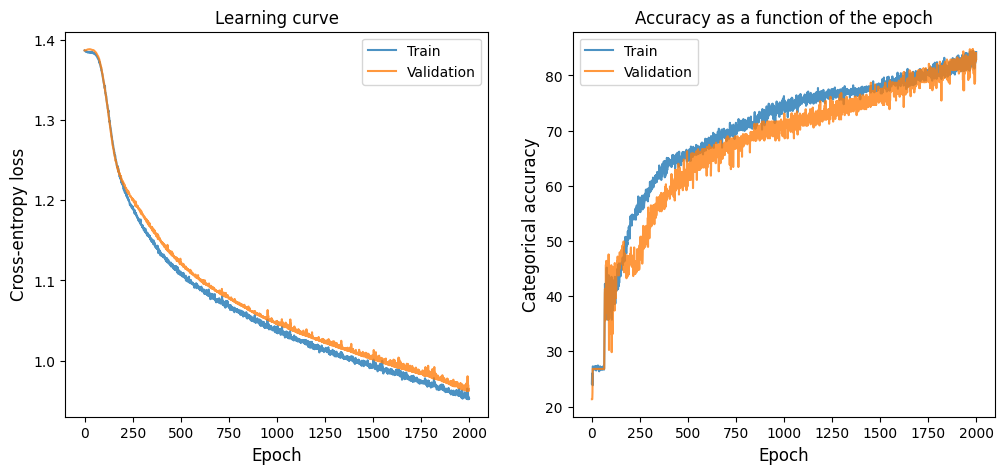

In [12]:
# Plot the learning curves
plot_history(history11)

*Discuss the training convergence*

We observe an initial flat period of little improvement in both plots around our ```max_patience``` value of $150$ epochs, followed by a rapid improvement in both training and validation loss and accuracy as the model adjusts its parameters to fit our training data. The accuracy plot appears to be much more jittery, especially on the validation data, although there is a clear upwards trend within which we see some gradual decrease in the fluctuations. In both plots, the rate of training convergence begins to decrease slightly for both training and validation data towards the end of our training limit of $2000$ epochs, but is still noticeable, which indicates that the model has opportunity for further improvement in accuracy and generalisation power before it levels out.

*Evaluate the classification accuracy on the test set and comment on the performance of the CNN.*

In [13]:
# Evaluating classification accuracy on the test set
preds11 = model11(torch.tensor(star_images_test, dtype=torch.float32).unsqueeze(1)).detach().numpy()

results1 = pd.DataFrame(columns=['Test Accuracy'])
results1.loc['1.1 CNN'] = [np.mean(np.argmax(preds11, axis=1) == star_classes_test)*100]
results1

,Test Accuracy
1.1 CNN,87.5


The classification accuracy on our test data is quite high, indicating that our CNN model is successfully classifying unseen data points. By increasing the training limit epochs, it could potentially be improved even more, although it may also overfit the training set. 



---



<a name="task-12"></a>

## (1.2) [(index)](#index-task-12)

*Keeping the same hyperparameters as in **1.1**, add regularisation to both 2-dimensional convolutional layers. Use the classification accuracy on the validation set to find the optimal penalty coefficient for the regularisation by scanning over values 0.001, 0.01, 0.1, 1, and 10. Using the optimal regularisation coefficient obtained, re-train the CNN on the training set.*

We implement this regularisation term into our ```training_loop``` function from earlier by taking in a new argument ```l2_reg``` which takes the value of our penalty coefficient $\beta$. If this new argument takes a value, we then add on the (scaled) extra regularisation term for the kernel weights $\mathbf{k}$ of both ```Conv2d``` layers:
$$L_{reg}(\mathbf{k}, \theta) = L(\mathbf{k},\theta) + \frac{\beta}{N}\sum_i k_i^2 $$
where $L(\mathbf{k}, \theta)$ is the ```CrossEntropyLoss``` function from Task **1.2** with mean reduction over the batches, and $N$ the size of the batch.

In [14]:
l2_regs = [0.001, 0.01, 0.1, 1, 10] # Penalty coefficients to scan over

# Retaining CNN on each penalty coefficient and returning the best model
model12, criterion12, optimiser12, l2_reg_best, history12 = None, None, None, None, None
acc_best = 0
hists = []

for l2_reg in l2_regs:
    # CNN with penalty
    mod, crit, opt = get_model(X1_train, n_filters1, k1, pool_size, stride_pool, n_filters2, k2, classes)
    
    # Calling the training loop
    mod, crit, opt, hist = train_CNN(mod, crit, opt, X1_train, y1_train, X1_val, y1_val, 
                                     max_num_epochs = max_num_epochs, 
                                     max_patience = max_patience,
                                     l2_reg = l2_reg)

    hists.append(hist)
    
    # Measure performance using accuracy on validation set
    acc = hist['validation_accuracy'][-1]
    print(f"l2_reg={l2_reg}, acc={acc}")
    if acc > acc_best:
        acc_best = acc
        model12, criterion12, optimiser12, l2_reg_best, history12 = mod, crit, opt, l2_reg, hist

l2_reg=0.001, acc=93.84191176470588
l2_reg=0.01, acc=93.84191176470588
Early stopping acting.
l2_reg=0.1, acc=26.81525735294118
Early stopping acting.
l2_reg=1, acc=26.81525735294118
Early stopping acting.
l2_reg=10, acc=26.81525735294118


In [15]:
print('Optimal value for L2 penalty term: ', l2_reg_best)

Optimal value for L2 penalty term:  0.001


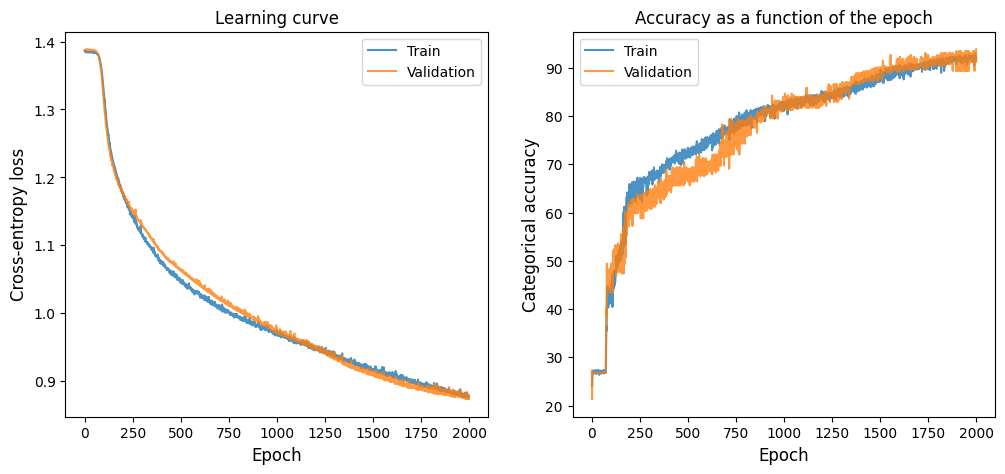

In [16]:
# Plot the learning curves
plot_history(history12)

*Evaluate the classification accuracy on the test set.*

In [17]:
# Predicting and evaluating on test set
preds12 = model12(torch.tensor(star_images_test, dtype=torch.float32).unsqueeze(1)).detach().numpy()
results1.loc['1.2 L2 Reg'] = [np.mean(np.argmax(preds12, axis=1) == star_classes_test)*100]
results1

,Test Accuracy
1.1 CNN,87.500
1.2 L2 Reg,90.625


*Discuss the performance of this CNN with regularisation in comparison to Task ***1.1***.*

We observe that the inclusion of a regularisation component to the ```Conv2d``` layers of our original CNN improves the classification accuracy of our CNN model on the test set. By adding l2 regularisation to the loss, we penalise large weights, which prevents overfitting and improves generalisation power. From the training, we see that smaller regularisation penalty terms $0.001$, $0.01$ perform better, whereas the larger ones perform worse and are stopped by the early stopping before any improvement can be seen.



---



<a name="task-13"></a>

## (1.3) [(index)](#index-task-12)

*First, create an imbalanced training set by randomly dropping half of the data points in class 3 (M5V) from the
original training set, and split the resulting dataset into 75% for actual training and 25% for validation.*

In [18]:
# Drop half the class 3 datapoints
idx_class3 = np.where(star_classes_train==3)[0]
np.random.seed(0)
idx_remove = np.random.choice(idx_class3, int(len(idx_class3)/2), replace=False)

X13_dropped = np.delete(star_images_train, idx_remove, axis=0)
y13_dropped = np.delete(star_classes_train, idx_remove)

In [19]:
# Split dropped data into training and validation
n13 = X13_dropped.shape[0]
np.random.seed(0)
val_ind = np.random.choice(n13, int(0.25*n13), replace=False)
train_ind = list(set(range(n13)) - set(val_ind))
X13_train = X13_dropped[train_ind]
X13_val = X13_dropped[val_ind]
y13_train = y13_dropped[train_ind]
y13_val = y13_dropped[val_ind]

*Re-train the CNN from Task 1.1 on this imbalanced training set, plotting training and validation accuracies during training.*

In [20]:
# CNN with imbalanced training set
model13, criterion13, optimiser13 = get_model(X13_train, n_filters1, k1, pool_size, stride_pool, n_filters2, k2, classes)

model13, criterion13, optimiser13, history13 = train_CNN(model13, criterion13, optimiser13, X13_train, y13_train, X13_val, y13_val, 
                                                 max_num_epochs = max_num_epochs, 
                                                 max_patience = max_patience)

Early stopping acting.


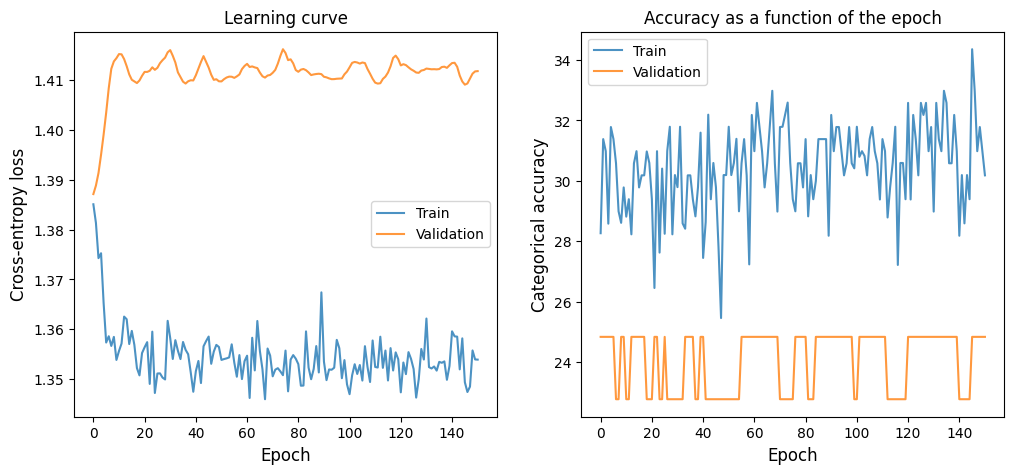

In [21]:
# Plot the learning curves
plot_history(history13)

*Report the accuracy on the test set of this re-trained CNN model and discuss your result.*


In [22]:
# Test predictions using new model
preds13 = model13(torch.tensor(star_images_test, dtype=torch.float32).unsqueeze(1)).detach().numpy()

results1.loc['1.3 CNN Unbalanced'] = [np.mean(np.argmax(preds13, axis=1) == star_classes_test)*100]
results1

,Test Accuracy
1.1 CNN,87.500
1.2 L2 Reg,90.625
1.3 CNN Unbalanced,25.000


With unbalanced classes in the training set, we notice that the CNN model training fails to improve within our ```max_patience``` of $150$ epochs, hence our model performs very poorly. The model has a test accuracy of $25\%$, which is very poor and on a similar level to a random classifier, indicating that our model fails to classify data sets with heavy imbalance in the number of data points in each class.

<u>*Reweighted loss function:*</u> *Modify the CNN loss function so that class 3 (now the minority class) has more weight,
choosing an appropriate reweighting strategy. Train the CNN from Task **1.1** with this reweighted loss, plotting the
training and validation accuracies during training.*

The weighting strategy we use is $$w_c = \frac{N}{N_c}$$ where $N$ is the number of data points in the training set, $w_c$ is the weight of class $c$, and $N_c$ is the number of data points in class $c$. We then modify the original ```get_model``` function to take a ```loss_weight``` argument that reweights the ```CrossEntropyLoss``` function with these weights.

In [23]:
# Weighting strategy: inverse frequency of each class
loss_weight = len(y13_train)/np.bincount(y13_train)
loss_weight = torch.tensor(loss_weight, dtype=torch.float32)

# Modified CNN with weighted loss
model13a, criterion13a, optimiser13a = get_model(X13_train, n_filters1, k1, pool_size, stride_pool, n_filters2, k2, classes, loss_weight=loss_weight)

model13a, criterion13a, optimiser13a, history13a = train_CNN(model13a, criterion13a, optimiser13a, X13_train, y13_train, X13_val, y13_val, 
                                                             max_num_epochs = max_num_epochs, 
                                                             max_patience = max_patience)

Epoch 998/2000, Training loss: 1.0239257216453552, Training accuracy: 73.16778273809523%, Validation loss: 1.0263053178787231, Validation accuracy: 73.27008928571428%
Epoch 999/2000, Training loss: 1.0430668592453003, Training accuracy: 70.19159226190477%, Validation loss: 1.025715947151184, Validation accuracy: 73.27008928571428%
Epoch 1000/2000, Training loss: 1.0311895608901978, Training accuracy: 73.53050595238095%, Validation loss: 1.0238915085792542, Validation accuracy: 70.92633928571428%
Epoch 1001/2000, Training loss: 1.0271530151367188, Training accuracy: 74.13504464285714%, Validation loss: 1.0250276923179626, Validation accuracy: 72.87946428571428%
Epoch 1002/2000, Training loss: 1.032158523797989, Training accuracy: 72.34002976190477%, Validation loss: 1.0271163284778595, Validation accuracy: 73.27008928571428%
Epoch 1003/2000, Training loss: 1.029085487127304, Training accuracy: 73.15848214285714%, Validation loss: 1.0211998522281647, Validation accuracy: 71.7075892857142

Epoch 1051/2000, Training loss: 1.027248501777649, Training accuracy: 71.75409226190477%, Validation loss: 1.018760234117508, Validation accuracy: 70.53571428571428%
Epoch 1052/2000, Training loss: 1.022862270474434, Training accuracy: 72.38653273809523%, Validation loss: 1.0200055539608002, Validation accuracy: 72.48883928571428%
Epoch 1053/2000, Training loss: 1.0284144282341003, Training accuracy: 71.56808035714286%, Validation loss: 1.0255176723003387, Validation accuracy: 73.66071428571428%
Epoch 1054/2000, Training loss: 1.036876603960991, Training accuracy: 71.72619047619048%, Validation loss: 1.0191686749458313, Validation accuracy: 72.09821428571428%
Epoch 1055/2000, Training loss: 1.0175080448389053, Training accuracy: 73.73511904761905%, Validation loss: 1.0197056233882904, Validation accuracy: 72.09821428571428%
Epoch 1056/2000, Training loss: 1.0174915343523026, Training accuracy: 74.73028273809523%, Validation loss: 1.0251508057117462, Validation accuracy: 74.051339285714

Epoch 1105/2000, Training loss: 1.0164709240198135, Training accuracy: 72.34002976190477%, Validation loss: 1.0151845514774323, Validation accuracy: 72.48883928571428%
Epoch 1106/2000, Training loss: 1.016289085149765, Training accuracy: 72.17261904761905%, Validation loss: 1.0172750055789948, Validation accuracy: 73.27008928571428%
Epoch 1107/2000, Training loss: 1.0075800269842148, Training accuracy: 76.29278273809523%, Validation loss: 1.0230466723442078, Validation accuracy: 72.48883928571428%
Epoch 1108/2000, Training loss: 1.022638589143753, Training accuracy: 74.48846726190477%, Validation loss: 1.0183578729629517, Validation accuracy: 73.27008928571428%
Epoch 1109/2000, Training loss: 1.018190711736679, Training accuracy: 76.07886904761905%, Validation loss: 1.017596572637558, Validation accuracy: 72.87946428571428%
Epoch 1110/2000, Training loss: 1.005799189209938, Training accuracy: 77.49255952380952%, Validation loss: 1.016964703798294, Validation accuracy: 73.66071428571428

Epoch 1159/2000, Training loss: 1.0052200257778168, Training accuracy: 77.87388392857143%, Validation loss: 1.013264924287796, Validation accuracy: 72.09821428571428%
Epoch 1160/2000, Training loss: 1.007639691233635, Training accuracy: 76.48809523809523%, Validation loss: 1.0132591724395752, Validation accuracy: 73.27008928571428%
Epoch 1161/2000, Training loss: 1.0088548213243484, Training accuracy: 73.13058035714286%, Validation loss: 1.0151627659797668, Validation accuracy: 74.44196428571428%
Epoch 1162/2000, Training loss: 1.0150164365768433, Training accuracy: 75.89285714285714%, Validation loss: 1.014473706483841, Validation accuracy: 73.66071428571428%
Epoch 1163/2000, Training loss: 1.0096720159053802, Training accuracy: 76.27418154761905%, Validation loss: 1.0127187669277191, Validation accuracy: 73.27008928571428%
Epoch 1164/2000, Training loss: 1.0089286863803864, Training accuracy: 76.68340773809523%, Validation loss: 1.0153062641620636, Validation accuracy: 74.05133928571

Epoch 1208/2000, Training loss: 1.0161864012479782, Training accuracy: 74.33035714285714%, Validation loss: 1.0126610398292542, Validation accuracy: 73.66071428571428%
Epoch 1209/2000, Training loss: 1.0084517747163773, Training accuracy: 75.28831845238095%, Validation loss: 1.0214060246944427, Validation accuracy: 72.87946428571428%
Epoch 1210/2000, Training loss: 1.0246229320764542, Training accuracy: 73.49330357142857%, Validation loss: 1.0133216083049774, Validation accuracy: 73.66071428571428%
Epoch 1211/2000, Training loss: 1.0104099661111832, Training accuracy: 76.06026785714286%, Validation loss: 1.0083502531051636, Validation accuracy: 72.87946428571428%
Epoch 1212/2000, Training loss: 1.0188111811876297, Training accuracy: 73.12127976190477%, Validation loss: 1.013605147600174, Validation accuracy: 74.44196428571428%
Epoch 1213/2000, Training loss: 1.0092535465955734, Training accuracy: 74.69308035714286%, Validation loss: 1.009707272052765, Validation accuracy: 72.8794642857

Epoch 1258/2000, Training loss: 1.0037494003772736, Training accuracy: 77.46465773809523%, Validation loss: 1.0081380903720856, Validation accuracy: 73.66071428571428%
Epoch 1259/2000, Training loss: 0.992767721414566, Training accuracy: 76.87872023809523%, Validation loss: 1.0083438754081726, Validation accuracy: 73.27008928571428%
Epoch 1260/2000, Training loss: 1.0061699599027634, Training accuracy: 73.33519345238095%, Validation loss: 1.009764701128006, Validation accuracy: 73.27008928571428%
Epoch 1261/2000, Training loss: 1.0130888372659683, Training accuracy: 75.87425595238095%, Validation loss: 1.014211893081665, Validation accuracy: 73.27008928571428%
Epoch 1262/2000, Training loss: 1.011523798108101, Training accuracy: 74.67447916666666%, Validation loss: 1.0069822072982788, Validation accuracy: 73.66071428571428%
Epoch 1263/2000, Training loss: 0.9995817840099335, Training accuracy: 76.28348214285714%, Validation loss: 1.0087184607982635, Validation accuracy: 74.051339285714

Epoch 1309/2000, Training loss: 0.9956978261470795, Training accuracy: 75.70684523809523%, Validation loss: 1.0044187605381012, Validation accuracy: 72.87946428571428%
Epoch 1310/2000, Training loss: 1.018152505159378, Training accuracy: 74.27455357142857%, Validation loss: 1.0098563134670258, Validation accuracy: 73.66071428571428%
Epoch 1311/2000, Training loss: 0.9944418221712112, Training accuracy: 77.26934523809523%, Validation loss: 1.0118209719657898, Validation accuracy: 73.27008928571428%
Epoch 1312/2000, Training loss: 1.0048055052757263, Training accuracy: 75.67894345238095%, Validation loss: 1.004310429096222, Validation accuracy: 73.66071428571428%
Epoch 1313/2000, Training loss: 1.0011087656021118, Training accuracy: 75.28831845238095%, Validation loss: 1.0059952437877655, Validation accuracy: 72.48883928571428%
Epoch 1314/2000, Training loss: 1.0049802958965302, Training accuracy: 72.93526785714286%, Validation loss: 1.0046201050281525, Validation accuracy: 73.2700892857

Epoch 1360/2000, Training loss: 0.9991040080785751, Training accuracy: 76.85081845238095%, Validation loss: 1.0061534345149994, Validation accuracy: 73.27008928571428%
Epoch 1361/2000, Training loss: 1.0189902037382126, Training accuracy: 73.45610119047619%, Validation loss: 1.0021165311336517, Validation accuracy: 72.87946428571428%
Epoch 1362/2000, Training loss: 0.9960364103317261, Training accuracy: 75.28831845238095%, Validation loss: 1.0029624700546265, Validation accuracy: 73.27008928571428%
Epoch 1363/2000, Training loss: 0.9814740419387817, Training accuracy: 76.49739583333334%, Validation loss: 1.0113164782524109, Validation accuracy: 74.44196428571428%
Epoch 1364/2000, Training loss: 1.0035021305084229, Training accuracy: 75.27901785714286%, Validation loss: 1.0025708973407745, Validation accuracy: 73.66071428571428%
Epoch 1365/2000, Training loss: 1.0008716434240341, Training accuracy: 76.08816964285714%, Validation loss: 1.0015685856342316, Validation accuracy: 73.66071428

Epoch 1409/2000, Training loss: 0.9893547892570496, Training accuracy: 77.06473214285714%, Validation loss: 1.0040033459663391, Validation accuracy: 73.27008928571428%
Epoch 1410/2000, Training loss: 0.9805343449115753, Training accuracy: 78.64583333333334%, Validation loss: 1.002479612827301, Validation accuracy: 73.66071428571428%
Epoch 1411/2000, Training loss: 0.9832203090190887, Training accuracy: 78.64583333333334%, Validation loss: 1.0005479156970978, Validation accuracy: 73.27008928571428%
Epoch 1412/2000, Training loss: 0.9977488815784454, Training accuracy: 77.04613095238095%, Validation loss: 1.003267228603363, Validation accuracy: 73.66071428571428%
Epoch 1413/2000, Training loss: 0.9871546775102615, Training accuracy: 77.25074404761905%, Validation loss: 1.0032581388950348, Validation accuracy: 73.27008928571428%
Epoch 1414/2000, Training loss: 0.9976694583892822, Training accuracy: 77.04613095238095%, Validation loss: 1.002794235944748, Validation accuracy: 73.66071428571

Epoch 1460/2000, Training loss: 0.9935219436883926, Training accuracy: 75.65104166666666%, Validation loss: 1.001177430152893, Validation accuracy: 73.27008928571428%
Epoch 1461/2000, Training loss: 0.9921200573444366, Training accuracy: 77.04613095238095%, Validation loss: 0.9991922676563263, Validation accuracy: 73.66071428571428%
Epoch 1462/2000, Training loss: 0.9809589385986328, Training accuracy: 78.04129464285714%, Validation loss: 1.0015411674976349, Validation accuracy: 73.66071428571428%
Epoch 1463/2000, Training loss: 0.9871952831745148, Training accuracy: 77.43675595238095%, Validation loss: 0.9977673888206482, Validation accuracy: 73.66071428571428%
Epoch 1464/2000, Training loss: 0.9998332262039185, Training accuracy: 74.46986607142857%, Validation loss: 1.0004409551620483, Validation accuracy: 73.27008928571428%
Epoch 1465/2000, Training loss: 0.9856113642454147, Training accuracy: 77.05543154761905%, Validation loss: 1.0004879534244537, Validation accuracy: 72.879464285

Epoch 1514/2000, Training loss: 0.9743748605251312, Training accuracy: 78.04129464285714%, Validation loss: 0.9962249994277954, Validation accuracy: 74.44196428571428%
Epoch 1515/2000, Training loss: 0.9940224438905716, Training accuracy: 77.43675595238095%, Validation loss: 0.9959376752376556, Validation accuracy: 73.66071428571428%
Epoch 1516/2000, Training loss: 0.9906815439462662, Training accuracy: 77.23214285714286%, Validation loss: 1.0017648041248322, Validation accuracy: 73.66071428571428%
Epoch 1517/2000, Training loss: 0.9745744615793228, Training accuracy: 77.65066964285714%, Validation loss: 0.998788058757782, Validation accuracy: 73.66071428571428%
Epoch 1518/2000, Training loss: 0.9733808934688568, Training accuracy: 79.82700892857143%, Validation loss: 0.9954233467578888, Validation accuracy: 74.44196428571428%
Epoch 1519/2000, Training loss: 0.9954696595668793, Training accuracy: 76.42299107142857%, Validation loss: 0.9974271357059479, Validation accuracy: 73.660714285

Epoch 1563/2000, Training loss: 0.980005145072937, Training accuracy: 76.24627976190477%, Validation loss: 0.9968285262584686, Validation accuracy: 74.05133928571428%
Epoch 1564/2000, Training loss: 0.9873241633176804, Training accuracy: 77.63206845238095%, Validation loss: 0.992957353591919, Validation accuracy: 74.44196428571428%
Epoch 1565/2000, Training loss: 0.979219377040863, Training accuracy: 78.42261904761905%, Validation loss: 0.994587630033493, Validation accuracy: 74.83258928571428%
Epoch 1566/2000, Training loss: 0.9699518531560898, Training accuracy: 79.23177083333334%, Validation loss: 1.0001899302005768, Validation accuracy: 74.05133928571428%
Epoch 1567/2000, Training loss: 0.9740557968616486, Training accuracy: 78.04129464285714%, Validation loss: 0.9967164397239685, Validation accuracy: 75.22321428571428%
Epoch 1568/2000, Training loss: 0.9813084155321121, Training accuracy: 78.21800595238095%, Validation loss: 0.9938456416130066, Validation accuracy: 74.832589285714

Epoch 1615/2000, Training loss: 0.9626785665750504, Training accuracy: 80.61755952380952%, Validation loss: 0.9911950528621674, Validation accuracy: 74.44196428571428%
Epoch 1616/2000, Training loss: 0.9693141430616379, Training accuracy: 79.22247023809523%, Validation loss: 0.9937894642353058, Validation accuracy: 74.05133928571428%
Epoch 1617/2000, Training loss: 0.967818558216095, Training accuracy: 78.22730654761905%, Validation loss: 0.9942993223667145, Validation accuracy: 75.22321428571428%
Epoch 1618/2000, Training loss: 0.9684906452894211, Training accuracy: 79.03645833333334%, Validation loss: 0.9930007457733154, Validation accuracy: 74.83258928571428%
Epoch 1619/2000, Training loss: 0.9614263623952866, Training accuracy: 79.83630952380952%, Validation loss: 0.9977926909923553, Validation accuracy: 74.05133928571428%
Epoch 1620/2000, Training loss: 0.9646633118391037, Training accuracy: 79.43638392857143%, Validation loss: 0.9937315583229065, Validation accuracy: 74.832589285

Epoch 1668/2000, Training loss: 0.9671265333890915, Training accuracy: 79.40848214285714%, Validation loss: 0.9870482087135315, Validation accuracy: 75.61383928571428%
Epoch 1669/2000, Training loss: 0.957708552479744, Training accuracy: 80.23623511904762%, Validation loss: 0.990752786397934, Validation accuracy: 74.05133928571428%
Epoch 1670/2000, Training loss: 0.9717150777578354, Training accuracy: 77.02752976190477%, Validation loss: 0.9982767105102539, Validation accuracy: 70.47991071428572%
Epoch 1671/2000, Training loss: 0.9629355370998383, Training accuracy: 79.81770833333334%, Validation loss: 0.9897719323635101, Validation accuracy: 75.22321428571428%
Epoch 1672/2000, Training loss: 0.9730211049318314, Training accuracy: 79.01785714285714%, Validation loss: 0.9877060055732727, Validation accuracy: 75.22321428571428%
Epoch 1673/2000, Training loss: 0.9631998538970947, Training accuracy: 79.82700892857143%, Validation loss: 1.002017229795456, Validation accuracy: 70.08928571428

Epoch 1721/2000, Training loss: 0.9589771926403046, Training accuracy: 81.21279761904762%, Validation loss: 0.9937744140625, Validation accuracy: 75.22321428571428%
Epoch 1722/2000, Training loss: 0.9690778851509094, Training accuracy: 77.62276785714286%, Validation loss: 0.9871703088283539, Validation accuracy: 74.44196428571428%
Epoch 1723/2000, Training loss: 0.9655845016241074, Training accuracy: 78.80394345238095%, Validation loss: 0.9888863265514374, Validation accuracy: 74.83258928571428%
Epoch 1724/2000, Training loss: 0.9655037224292755, Training accuracy: 79.20386904761905%, Validation loss: 0.9985373318195343, Validation accuracy: 74.83258928571428%
Epoch 1725/2000, Training loss: 0.9608150273561478, Training accuracy: 79.61309523809523%, Validation loss: 0.98736771941185, Validation accuracy: 74.83258928571428%
Epoch 1726/2000, Training loss: 0.9813772886991501, Training accuracy: 78.60863095238095%, Validation loss: 0.9853114783763885, Validation accuracy: 75.6138392857142

Epoch 1770/2000, Training loss: 0.9469654560089111, Training accuracy: 82.39397321428572%, Validation loss: 0.989563912153244, Validation accuracy: 75.22321428571428%
Epoch 1771/2000, Training loss: 0.9658378511667252, Training accuracy: 79.41778273809523%, Validation loss: 0.9841567873954773, Validation accuracy: 76.00446428571428%
Epoch 1772/2000, Training loss: 0.9722795784473419, Training accuracy: 80.98958333333334%, Validation loss: 0.987352579832077, Validation accuracy: 74.05133928571428%
Epoch 1773/2000, Training loss: 0.9548443406820297, Training accuracy: 80.20833333333334%, Validation loss: 0.9833999276161194, Validation accuracy: 74.83258928571428%
Epoch 1774/2000, Training loss: 0.9663234502077103, Training accuracy: 79.39918154761905%, Validation loss: 0.9862140715122223, Validation accuracy: 75.61383928571428%
Epoch 1775/2000, Training loss: 0.9575956165790558, Training accuracy: 80.19903273809523%, Validation loss: 0.9879726767539978, Validation accuracy: 76.0044642857

Epoch 1824/2000, Training loss: 0.95981465280056, Training accuracy: 78.99925595238095%, Validation loss: 0.9877417683601379, Validation accuracy: 76.00446428571428%
Epoch 1825/2000, Training loss: 0.9611991047859192, Training accuracy: 79.20386904761905%, Validation loss: 0.9795820713043213, Validation accuracy: 76.00446428571428%
Epoch 1826/2000, Training loss: 0.9688115268945694, Training accuracy: 78.98995535714286%, Validation loss: 0.9851403832435608, Validation accuracy: 75.61383928571428%
Epoch 1827/2000, Training loss: 0.9597351998090744, Training accuracy: 79.20386904761905%, Validation loss: 0.9831983149051666, Validation accuracy: 76.39508928571428%
Epoch 1828/2000, Training loss: 0.9506831467151642, Training accuracy: 81.97544642857143%, Validation loss: 0.979270875453949, Validation accuracy: 76.00446428571428%
Epoch 1829/2000, Training loss: 0.9454159438610077, Training accuracy: 81.79873511904762%, Validation loss: 0.983246237039566, Validation accuracy: 75.613839285714

Epoch 1877/2000, Training loss: 0.9500302523374557, Training accuracy: 83.35193452380952%, Validation loss: 0.9796131253242493, Validation accuracy: 76.39508928571428%
Epoch 1878/2000, Training loss: 0.9512361884117126, Training accuracy: 81.18489583333334%, Validation loss: 0.9837835431098938, Validation accuracy: 75.61383928571428%
Epoch 1879/2000, Training loss: 0.953776016831398, Training accuracy: 79.80840773809523%, Validation loss: 0.9776195585727692, Validation accuracy: 75.61383928571428%
Epoch 1880/2000, Training loss: 0.9631104171276093, Training accuracy: 79.79910714285714%, Validation loss: 0.9796418249607086, Validation accuracy: 76.00446428571428%
Epoch 1881/2000, Training loss: 0.9566639214754105, Training accuracy: 80.37574404761905%, Validation loss: 0.9822772741317749, Validation accuracy: 76.78571428571428%
Epoch 1882/2000, Training loss: 0.9492235779762268, Training accuracy: 81.58482142857143%, Validation loss: 0.9795625507831573, Validation accuracy: 76.004464285

Epoch 1931/2000, Training loss: 0.943461686372757, Training accuracy: 83.16592261904762%, Validation loss: 0.9743007719516754, Validation accuracy: 76.78571428571428%
Epoch 1932/2000, Training loss: 0.9368475377559662, Training accuracy: 82.57068452380952%, Validation loss: 0.9747779667377472, Validation accuracy: 76.39508928571428%
Epoch 1933/2000, Training loss: 0.9445010125637054, Training accuracy: 81.17559523809523%, Validation loss: 0.9771285951137543, Validation accuracy: 76.39508928571428%
Epoch 1934/2000, Training loss: 0.9344110488891602, Training accuracy: 82.97061011904762%, Validation loss: 0.9735432267189026, Validation accuracy: 76.39508928571428%
Epoch 1935/2000, Training loss: 0.947700709104538, Training accuracy: 80.38504464285714%, Validation loss: 0.9729357957839966, Validation accuracy: 76.39508928571428%
Epoch 1936/2000, Training loss: 0.9502849578857422, Training accuracy: 80.37574404761905%, Validation loss: 0.9812120199203491, Validation accuracy: 72.8236607142

Epoch 1983/2000, Training loss: 0.9377138316631317, Training accuracy: 82.57068452380952%, Validation loss: 0.9725570380687714, Validation accuracy: 77.17633928571428%
Epoch 1984/2000, Training loss: 0.9246039241552353, Training accuracy: 84.34709821428572%, Validation loss: 0.9683457314968109, Validation accuracy: 77.17633928571428%
Epoch 1985/2000, Training loss: 0.9357164949178696, Training accuracy: 84.14248511904762%, Validation loss: 0.9744064509868622, Validation accuracy: 77.17633928571428%
Epoch 1986/2000, Training loss: 0.9428672194480896, Training accuracy: 80.57105654761905%, Validation loss: 0.9741791188716888, Validation accuracy: 76.78571428571428%
Epoch 1987/2000, Training loss: 0.9450844675302505, Training accuracy: 80.37574404761905%, Validation loss: 0.9695524275302887, Validation accuracy: 76.78571428571428%
Epoch 1988/2000, Training loss: 0.9296405017375946, Training accuracy: 82.97991071428572%, Validation loss: 0.9712622463703156, Validation accuracy: 77.17633928

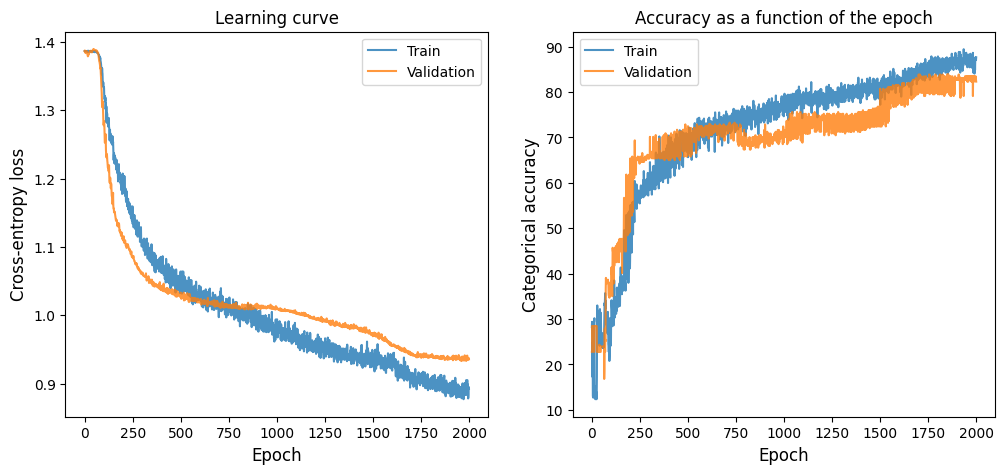

In [24]:
# Plot the learning curves
plot_history(history13a)

*Report and discuss the test accuracy.*

In [25]:
preds13a = model13a(torch.tensor(star_images_test, dtype=torch.float32).unsqueeze(1)).detach().numpy()

results1.loc['1.3 CNN Reweighted'] = [np.mean(np.argmax(preds13a, axis=1) == star_classes_test)*100]
results1

,Test Accuracy
1.1 CNN,87.500
1.2 L2 Reg,90.625
1.3 CNN Unbalanced,25.000
1.3 CNN Reweighted,93.750


By implementing our weighting strategy to the loss function, the classification accuracy of the test data improves drastically, and we get a significantly better score.

<u>*Data augmentation:*</u> *To re-balance the training data, produce new training data of the minority class (Class 3) by
using each image in the depleted class 3 to obtain an additional training image by adding Gaussian noise on each
pixel drawn.*

*Once you have generated the augmented dataset, repeat the steps above: split the training set into 75% for actual
training and 25% for validation; use the validation set to find an optimal value for by scanning over the values
0.01, 0.1 and 1; re-train the CNN architecture from Task 1.1 on this augmented dataset, plotting training and
validation accuracies during training.*

In [26]:
c_values = [0.01, 0.1, 1] # c values to scan over

idx3 = np.where(y13_dropped==3)[0] # Get indices of class 3 in dropped dataset
sig_p = np.std(X13_dropped[idx3], axis=0) # Get standard deviation of class 3

# Training CNN for different c and returning best model
bestc, model13b, criterion13b, optimiser13b, history13b = None, None, None, None, None
acc_best = 0

for c in c_values:
    np.random.seed(0)
    
    # Augmented imbalanced training data by adding Gaussian noise
    X13aug = np.vstack([X13_dropped, 
                        X13_dropped[idx3] + np.random.normal(0, 
                                                             np.sqrt(c)*sig_p, 
                                                             size=(len(idx3),) + sig_p.shape)])
    y13aug = np.concatenate([y13_dropped, np.full(len(idx3), 3)])
    
    # Split data into training and validation
    n13 = X13aug.shape[0]
    np.random.seed(0)
    val_ind = np.random.choice(n13, int(0.25*n13), replace=False)
    train_ind = list(set(range(n13)) - set(val_ind))
    X13_train = X13aug[train_ind]
    X13_val = X13aug[val_ind]
    y13_train = y13aug[train_ind]
    y13_val = y13aug[val_ind]
    
    # CNN with augmented data
    mod, crit, opt= get_model(X13_train, n_filters1, k1, pool_size, stride_pool, n_filters2, k2, classes)

    mod, crit, opt, hist = train_CNN(mod, crit, opt, X13_train, y13_train, X13_val, y13_val, 
                                                                 max_num_epochs = max_num_epochs, 
                                                                 max_patience = max_patience,
                                                                 display = False)
    
    acc = hist['validation_accuracy'][-1]
    print(f"c={c}, acc={acc}")
    if acc > acc_best:
        acc_best = acc
        bestc, model13b, criterion13b, optimiser13b, history13b = c, mod, crit, opt, hist

c=0.01, acc=87.27022058823529
c=0.1, acc=81.59466911764706
c=1, acc=82.67463235294117


In [27]:
print('Optimal value for c: ', bestc)

Optimal value for c:  0.01


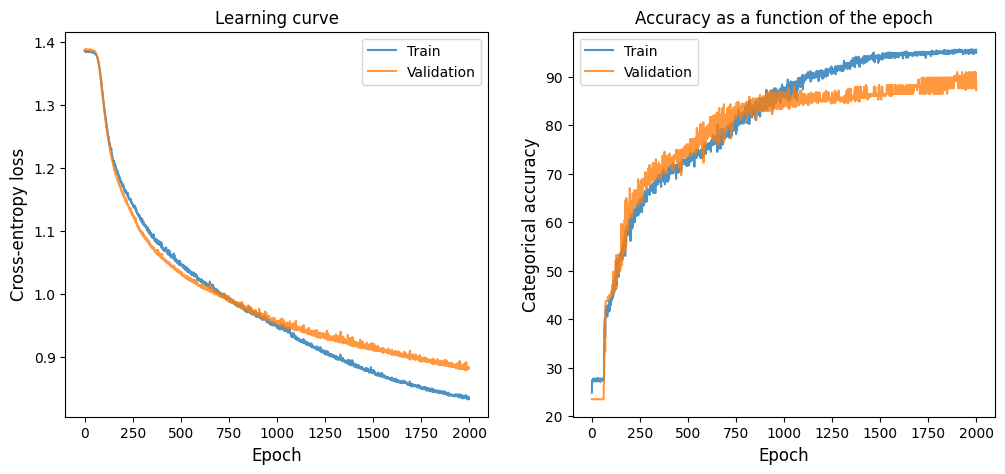

In [28]:
plot_history(history13b)

*Report and discuss the test accuracy.*

In [29]:
preds13b = model13b(torch.tensor(star_images_test, dtype=torch.float32).unsqueeze(1)).detach().numpy()
results1.loc['1.3 CNN Data Augmented'] = [np.mean(np.argmax(preds13b, axis=1) == star_classes_test)*100]
results1

,Test Accuracy
1.1 CNN,87.500
1.2 L2 Reg,90.625
1.3 CNN Unbalanced,25.000
1.3 CNN Reweighted,93.750
1.3 CNN Data Augmented,93.750


Again, we see drastic improvement in the classification accuracy of the test data by augmenting our data to balance the classes more. For all $c$ values, the validation accuracy is high, and by adjusting it we get an optimal value of ```0.01``` from our initial choices.

*Finally, conclude 1.3 by discussing the effect of the two strategies (reweighted loss function and data
augmentation), comparing their performance.*

In conclusion, both strategies we use to handle imbalanced training data perform well, and significantly better than having no strategy at all. Since they both have the same classification accuracy on the test data, it is difficult to say which is better. The first strategy modifies the training process directly by adding weights to the loss function, whereas the second strategy augments the data itself, hence both strategies could be implemented together in further tests on improving classification of unseen data. 



---



<a name="task-2"></a>

# (2) Task 2: Dimensionality Reduction: PCA vs ISOMAP [(index)](#index-task-2)

In [30]:
# We define node/class colours for plot consistency
cmap = matplotlib.colormaps.get_cmap('tab10')
color_type = [cmap(i) for i in star_classes_train]

# Transform node/class values to class names
value_to_type = {0 : "O5V", 1: "A0V", 2 : "F5V", 3 : "M5V"}

<a name="task-21"></a>

## (2.1) [(index)](#index-task-21)

*Perform Principal Component Analysis (PCA) of the embedding vectors provided in ```star_embeddings_train.npy```, following the standard PCA algorithm with data standardisation.*

We standardise the data using function seen in coding task.

In [31]:
def standardise(X):
    """
    Arguments:
    X: Data with samples being indexed along axis 0.

    Returns:
    Xbar: Standardised data.

    """
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std[std==0] = 1.
    Xbar = (X - mu) / std
    
    return Xbar

In [32]:
# Standardise data for PCA
X2_norm = standardise(star_embeddings_train)

We implement the covariance matrix and PCA function as seen in coding task.

In [33]:
def covariance_matrix(X):
    """
    Arguments:
    X: Data with samples being indexed along axis 0.

    Returns:
    Xbar: Computes the data covariance matrix.

    """
    return np.dot(X.T, X) / len(X)

def pca_function(X, k):
    """
    Arguments:
    X: Data with samples being indexed along axis 0.
    k: Number of principal components.

    Returns:
    X_pca: Transformed data.
    eigenvectors: First k eigenvectors of C.
    eigenvalues: First k eigenvalues of C.

    """
    # Computing the covariance matrix
    C = covariance_matrix(X)

    # Computing the eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(C, k, which='LM', return_eigenvectors=True)
    
    # Sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(abs(eigenvalues))[::-1]
    eigenvalues = eigenvalues[sorted_index]
    eigenvectors = eigenvectors[:,sorted_index]

    # Projecting the data onto the directions of eigenvectors
    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

In [34]:
k = 2 # We want first 2 principal components 

X2_pca, eigenvectors, eigenvalues = pca_function(X2_norm, k)

*Visualise each embedding in the 2D space of the first two principal components of PCA, colouring each embedding according to their star class.*

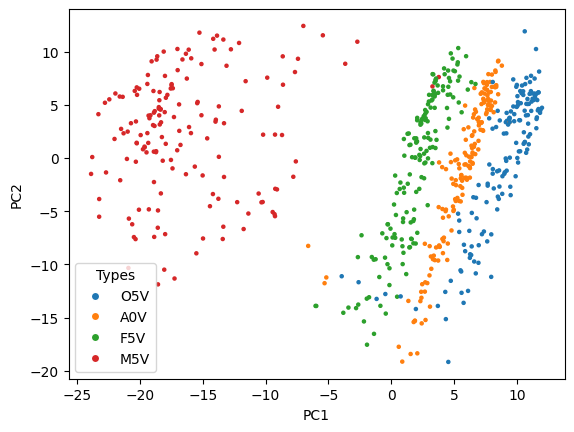

In [35]:
plt.scatter(X2_pca[:, 0], X2_pca[:, 1], c=color_type, s=5)

# create legend for node types
types_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=cmap(value)) for value, label in value_to_type.items()]
plt.legend(handles=types_legend, title='Types')

plt.xlabel('PC1')
plt.ylabel('PC2');

*Discuss your results.*

From the scatter plot, we observe distinct clusters between the 4 classes. PCA appears to separate the classes rather successfully. The first 3 classes appear to be distinct vertical (slightly diagonal) parallel strips, with positive values over the first principal component *PC1*, and the last ```M5V``` class appears to be very spread out on the negative end of *PC1* in a different pattern. They also appear to be in order of temperature, with stars in the hotter classes having a higher *PC1* value. Hence the first principal component has successfully captured patterns within the embeddings of the stars. All classes vary across ```PC2```, but there appears to be a linear relationship between the first two principal components across the hotter star classes ```O5V```, ```A0V```, and ```F5V```, possibly due to some sort of common feature or underlying structure within the star embeddings. The cooler star class ```M5V``` is more scattered and is further separated from the other classes, with little structure or relationship detected by *PC2*, which may reflect more variability within the embeddings of the stars in this class.

*Next, evaluate how well this 2D representation matches the division into classes. Consider the 2D representations
of the embeddings, and each class as a ‘cluster’ to compute the Davies-Bouldin Index $DB$ measure of clustering
quality.*

We implement the ```compute_centroids``` function as seen in coding task.

In [36]:
def compute_centroids(k, X, labels):
    """
    Compute the centroids of the clustered points X.

    Args:
        k (int): total number of clusters.
        X (np.ndarray): data points, with shape (N, p)
        labels (np.ndarray): cluster assignments for each sample in X, with shape (N,).

    Returns:
        (np.ndarray): the centroids of the k clusters, with shape (k, p).
    """
    N, p = X.shape

    centroids = np.zeros((k, p))

    # EDIT THE NEXT LINES
    for label in range(k):
        cluster_X_l = X[labels == label]
        centroids[label] = cluster_X_l.mean(axis=0)

    return centroids

We implement a new function ```calculate_DB``` which calculates the Davies-Bouldin Index given an input and its class labels.

In [37]:
def calculate_DB(X, class_labels):
    """
    Calculate Davies-Bouldin Index.
    
    Args:
        X: data points
        class_labels: class assignments for each data point
    """
    # Get the indices of data points corresponding to each class
    classes = set(class_labels)
    indices_dict = {cl: [] for cl in classes}
    for i, class_i in enumerate(star_classes_train):
        indices_dict[class_i].append(i)
    class_indices = [indices_dict[cl] for cl in classes]
    
    num_classes = len(class_indices) # get number of classes
    centroids = compute_centroids(num_classes, X, class_labels) # compute centroids, centroid[i] is centroid of class i
    
    S = np.array(
        [np.mean(np.linalg.norm(X[class_indices[cl]] - centroids[cl], axis=1)) for cl in np.arange(num_classes)]
    ) # S[i] is the average distance from point i to its cluster centroid
    
    M = np.linalg.norm(centroids[:, None] - centroids, axis=2) # M[i,j] is distance between centroid i and j
    M[np.where(M==0)] = 1e-5 # to prevent divide by 0 error
    
    F = (S[:, None] + S)/M # F[i,j] is (S[i] + S[j])/M[i,j]
    F = np.where(np.eye(F.shape[0], dtype=bool), 0, F) # Set the diagonals to minimum value (0)
    
    DB = np.mean(np.max(F, axis=0)) # DB is mean of max rows of F
    return DB

In [38]:
# Calculate DB
DB = calculate_DB(X2_pca[:,:2], star_classes_train)

results2 = pd.DataFrame(columns=['Davies-Bouldin Index'])
results2.loc['2.1 PCA'] = [DB]
results2

,Davies-Bouldin Index
2.1 PCA,2.85337


*Discuss your results in terms of $DB$.*

The Davies-Bouldin index can be interpreted as a function of the ratio of the scatter within clusters, to the separation between clusters. It is difficult to tell whether this is a good result or not as we do not have a measure to compare this value to, but it is useful to know that a lower DB index is better, as it indicates better clustering.



---



<a name="task-22"></a>

## (2.2) [(index)](#index-task-22)

*Next you will implement dimensionality reduction using an algorithm inspired by Isomap. First, we construct a graph where each embedding vector is a node of the graph. Compute the matrix $D$ of pairwise cosine distances.*

In [39]:
# Computing D
norms = np.linalg.norm(star_embeddings_train, axis=1) # Norms of Xi
D = 1 - (star_embeddings_train @ star_embeddings_train.T)/(norms[:,None]*norms)

*From the cosine distance matrix $D$, construct the adjacency matrix $A$ of the $k$-Nearest Neighbour ($k$NN) graph for $k=9$.*

In [40]:
k = 9

# Construct A
A = np.zeros((D.shape[0], D.shape[0]))
for i in range(D.shape[0]):
    idx_neighbours = np.argsort(D[i])[1:k+1]
    A[i, idx_neighbours] = D[i, idx_neighbours]
    A[idx_neighbours, i] = D[idx_neighbours, i]
    

*Visualise the graph corresponding to $A$ using the spectral layout introduced in the Notebook from Week 9, where the x- and y-coordinates of the nodes are given by the entries of the normalised second and third eigenvectors of the symmetric normalised graph Laplacian.*

In [41]:
# compute degrees
degree = A.sum(axis=0)

# compute combinatorial Laplacian
L = np.diag(degree) - A            

# compute square root of inverse diagonal degree matrix
D_sqrt_inv = np.diag(1/np.sqrt(degree))   

# compute symmetric normalised Laplacian
L_s = D_sqrt_inv @ L @ D_sqrt_inv    

# compute eigen decomposition
eigenvals, eigenvecs = np.linalg.eigh(L_s)       

# sort eigenvalues and corresponding eigenvector
eigenvecs = eigenvecs.T[np.argsort(eigenvals)]   
eigenvals = np.sort(eigenvals) 

# get second (Fiedler) and third eigenvectors
v2 = eigenvecs[1]       
v3 = eigenvecs[2]       

# normalise coordinates
x = D_sqrt_inv @ v2     
y = D_sqrt_inv @ v3     

*Colour the nodes of the graph according to star types, and discuss the layout of the $k$NN graph in
relation to the star classes. Explain your results.* 

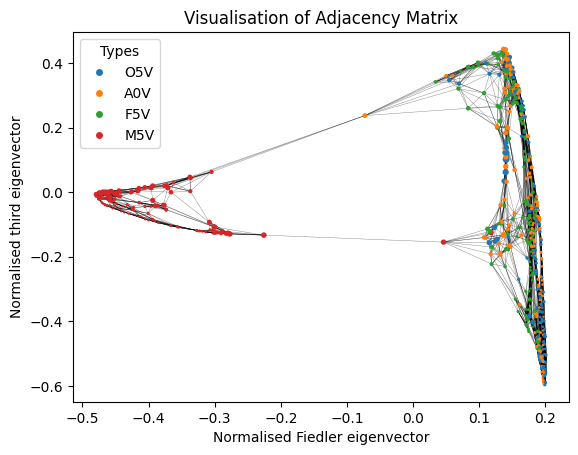

In [42]:
# plot
fig, ax = plt.subplots(1)

# plot edges
for i in range(A.shape[0]):
    for j in range(i+1,A.shape[0]):
        if A[i,j] > 0:
            ax.plot([x[i],x[j]],[y[i],y[j]], color="black", alpha=0.5, linewidth=0.3)

# plot nodes
scatter = ax.scatter(x,y,s=100*degree, c=color_type, zorder=10)

# create legend for node types
types_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=cmap(value)) for value, label in value_to_type.items()]
plt.legend(handles=types_legend, title='Types')

# set labels
ax.set(xlabel="Normalised Fiedler eigenvector", ylabel="Normalised third eigenvector", title="Visualisation of Adjacency Matrix")

plt.show()

The spectral layout of the $k$NN graph displays an interesting structure in the distribution of the star embeddings. The colder ```M5V``` class appears to be clustered around the negative side of the Fielder eigenvector, and centred on 0 with respect to the third eigenvector. This close clustering suggests that these stars share common characteristics captured by the embedding vectors. The other classes appear to be tightly clustered with a positive component of the Fielder eigenvector, but greatly dispersed among the third eigenvector. They are significantly more intertwined, with little distinct boundaries between the classes. These results indicate that the hotter stars in the 3 classes, ```O5V```, ```A0V```, and ```F5V```, could not be distinguished from each other by the spectral layout of the $k$NN graph, and they may share more similar characteristics with each other in their embeddings compared to the ```M5V``` class, which has been distinctly separated by the graph. 



---



<a name="task-22"></a>

## (2.3) [(index)](#index-task-23)

*The second step in the Isomap-like algorithm is to compute distances between nodes in the graph constructed in **2.2**. In particular, compute the resistance distance matrix $R$.*

In [43]:
# Compute Gamma using the Laplacian from 2.2
Gamma = np.linalg.pinv(L - (np.ones(L.shape[0]) @ np.ones(L.shape[0]).T))
# Compute resistance distance matrix R
R = np.diag(Gamma) + np.diag(Gamma)[:, None] - 2* Gamma

*Use a scatter plot to represent, for each $i$, the mean cosine distance from $X_i$ to all other data points (computed in
Task **2.2**) against the mean resistance distance from node $i$ to all other nodes.*

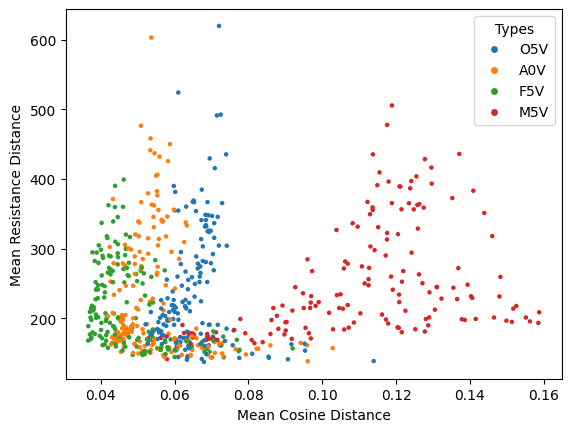

In [44]:
D_mean = np.mean(D, axis=0) # mean cosine distance
R_mean = np.mean(R, axis=0) # mean resistance distance

# scatter plot
plt.scatter(D_mean, R_mean, s=5, c=color_type)
plt.xlabel('Mean Cosine Distance')
plt.ylabel('Mean Resistance Distance')

# create legend for node types
types_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=cmap(value)) for value, label in value_to_type.items()]
plt.legend(handles=types_legend, title='Types');

*Comment on and explain the differences that you observe between the two distances.*

The scatter plots reveals little correlation between the distance measurements. Mean cosine distance appears to separate the classes more successfully, as we observe stars in the ```F5V``` class have, on average, the least cosine distance to other stars, followed by ```A0V```, ```O5V```, then ```M5V```, of which the stars in this class have much more deviation in their mean cosine distance compared to the other classes, taking on much higher values. When considering mean resistance distance however, there appears to be less distinction between the stars in each class, and all classes seem to vary greatly in their mean resistance distance to other stars, although most appear to be clustered at a lower value with a positive skew. 

*Finally, obtain a 2D projection of the graph distances, by computing the centred distance matrix $\tau$ from the
resistance distance matrix $R$.*

In [45]:
H = np.identity(L.shape[0]) - (1/L.shape[0]) * np.ones((L.shape[0],1)) @ np.ones((L.shape[0],1)).T
Tau = -(1/2) * H @ R**2 @ H

*Find the eigenvectors of $\tau$.*

In [46]:
# Computing the eigenvalues and eigenvectors
tau_eigenvalues, tau_eigenvectors = scipy.sparse.linalg.eigsh(Tau, 2, which='LA', return_eigenvectors=True)

# Sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
sorted_index = np.argsort(tau_eigenvalues)[::-1]
tau_eigenvalues = tau_eigenvalues[sorted_index]
tau_eigenvectors = tau_eigenvectors[:,sorted_index]

*Visualise the embeddings in the 2D space of the top two eigenvectors of (i.e., corresponding to the two eigenvalues with the largest value), colouring each embedding according to their star class.*

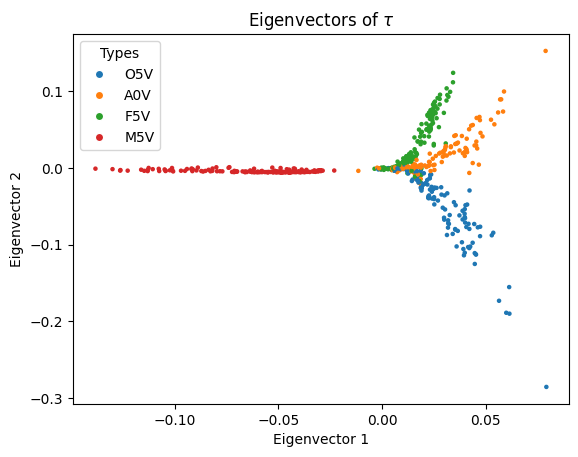

In [47]:
# scatter plot
plt.scatter(tau_eigenvectors[:, 0], tau_eigenvectors[:, 1], c=color_type, s=5)

# create legend for node types
types_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=cmap(value)) for value, label in value_to_type.items()]
plt.legend(handles=types_legend, title='Types')

plt.xlabel('Eigenvector 1')
plt.ylabel('Eigenvector 2')
plt.title(r'Eigenvectors of $\tau$');

*Evaluate how well this 2D representation matches the division into classes by calculating the $DB$ index, as in
Task **2.1**, and compare it to the results obtained from the 2D representation from PCA in Task **2.1**. Discuss and
explain the observed differences.*

In [48]:
DB2 = calculate_DB(tau_eigenvectors[:,:2], star_classes_train)
results2.loc['2.3 Isomap-like'] = [DB2]
results2

,Davies-Bouldin Index
2.1 PCA,2.853370
2.3 Isomap-like,1.938793


The plot of the star embeddings against the first 2 principal components of $\tau$ quite successfully divides stars of the same class into distinct clusters. Stars in the  ```M5V``` class are again shown to be much more separate from the other classes, and are distinctly separated by the first eigenvector, and also have the greatest deviation along this eigenvector, suggesting they have the most distinct characteristics in comparison to the other classes. Along the second eigenvector, we observe that the other classes can be discerned by a varying linear relationship between their components along the first two eigenvectors. The hottest class ```O5V``` appears to have been separated the most by the second eigenvector, and the other 2 classes seem to be more intertwined, but their difference can be noticed by the correlation between the eigenvectors. The ```M5V``` class seems to be clustered very closely around 0 on the second eigenvector, possibly showing that a key common characteristic between the embeddings of the stars in this class has been captured by it.

Compared to the PCA plot as in Task *2.1*, the variance in the points appears to be much lower, as most points lie close together. Both *PC1* and the largest eigenvector of $\tau$ successfully separate the ```M5V``` class distinctly, and group the other 3 classes more closely. On a 2D representation, both PCA and the Isomap-like algorithm successfully distinguish between the 3 classes. The eigenvectors of $\tau$ are not restricted by the assumption of a linear relationship between the variables, unlike PCA, which is likely why there is significantly less scatter within each cluster. This is supported by our $DB$ index result of $1.94$, which is less than the value of $2.85$ we got for PCA, implying that the Isomap-like algorithm has a higher ratio of scatter within clusters to distance between clusters. Therefore we can conclude that the Isomap-like algorithm is more successful at dimensionality reduction then the PCA algorithm.



---

